<a href="https://colab.research.google.com/github/haidershoaib98/TGCN-Reproduce/blob/main/6322_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Installs

In [ ]:
!apt install libspatialindex-dev
!pip install osmnx

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
0 upgraded, 3 newly installed, 0 to remove and 39 not upgraded.
Need to get 555 kB of archives.
After this operation, 3,308 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-dev amd64 1.8.5-5 [285 kB]
Fetched 555 kB in 2s (264 kB/s)
Selecting previously unselected package libspatialindex4v5:amd64.
(Reading database ... 156210 files and directories currently installed.)
Preparing to unpack .../libspatialindex4v5_1.8.5-5_

In [ ]:
!pip install python-utils

In [ ]:
!pip install git+https://github.com/PyTorchLightning/pytorch-lightning
import pytorch_lightning as pl

  Cloning https://github.com/PyTorchLightning/pytorch-lightning to /tmp/pip-req-build-miioyoyj
  Running command git clone -q https://github.com/PyTorchLightning/pytorch-lightning /tmp/pip-req-build-miioyoyj
  Running command git submodule update --init --recursive -q
  From https://github.com/PyTorchLightning/lightning-tutorials
   * branch            290fb466de1fcc2ac6025f74b56906592911e856 -> FETCH_HEAD
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 398 kB 4.2 MB/s 
     |████████████████████████████████| 136 kB 51.9 MB/s 
     |████████████████████████████████| 596 kB 43.7 MB/s 
     |████████████████████████████████| 1.1 MB 48.2 MB/s 
     |████████████████████████████████| 271 kB 47.5 MB/s 
     |████████████████████████████████| 144 kB 48.9 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 
  Created wheel for pytorch-lightning: filename=pytorch_light

In [ ]:
# Import Python libraries
import numpy as np
import pandas as pd
import scipy.stats as sp
import torch
import torch.nn as nn
from torch.nn.functional import normalize
import torch.optim
import torch.nn.functional as F
import torchmetrics
from torch.utils.data.dataloader import DataLoader

# Dataset Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/haidershoaib98/TGCN-Reproduce.git

Cloning into 'TGCN-Reproduce'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 45 (delta 9), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (45/45), done.


Getting data from github clone

In [40]:
# Los Loop
f = pd.read_csv('TGCN-Reproduce/data/los_speed.csv')
f_adj = pd.read_csv('TGCN-Reproduce/data/los_adj.csv', header=None)
data = np.array(f, dtype=np.float32)
adj = np.array(f_adj, dtype=np.float32)

This cell creates the dataset into tensors (Taken from T-GCN source code since it is a very specific way to seperate the training and testing sets)

In [ ]:
def generate_dataset(
    data, seq_len, pre_len, time_len=None, split_ratio=0.8, normalize=True
):
    """
    :param data: feature matrix
    :param seq_len: length of the train data sequence
    :param pre_len: length of the prediction data sequence
    :param time_len: length of the time series in total
    :param split_ratio: proportion of the training set
    :param normalize: scale the data to (0, 1], divide by the maximum value in the data
    :return: train set (X, Y) and test set (X, Y)
    """
    if time_len is None:
        time_len = data.shape[0]
    if normalize:
        max_val = np.max(data)
        data = data / max_val
    train_size = int(time_len * split_ratio)
    train_data = data[:train_size]
    test_data = data[train_size:time_len]
    train_X, train_Y, test_X, test_Y = list(), list(), list(), list()
    for i in range(len(train_data) - seq_len - pre_len):
        train_X.append(np.array(train_data[i : i + seq_len]))
        train_Y.append(np.array(train_data[i + seq_len : i + seq_len + pre_len]))
    for i in range(len(test_data) - seq_len - pre_len):
        test_X.append(np.array(test_data[i : i + seq_len]))
        test_Y.append(np.array(test_data[i + seq_len : i + seq_len + pre_len]))
    return np.array(train_X), np.array(train_Y), np.array(test_X), np.array(test_Y)


def generate_torch_datasets(
    data, seq_len, pre_len, time_len=None, split_ratio=0.8, normalize=True
):
    train_X, train_Y, test_X, test_Y = generate_dataset(
        data,
        seq_len,
        pre_len,
        time_len=time_len,
        split_ratio=split_ratio,
        normalize=normalize,
    )
    train_dataset = torch.utils.data.TensorDataset(
        torch.FloatTensor(train_X), torch.FloatTensor(train_Y)
    )
    test_dataset = torch.utils.data.TensorDataset(
        torch.FloatTensor(test_X), torch.FloatTensor(test_Y)
    )
    return train_dataset, test_dataset

Generate train and test data

In [42]:

tr_x, tr_y, tx, ty = generate_dataset(data, 12, 3)
train, test = generate_torch_datasets(data, 12, 3)
train_data = DataLoader(train, batch_size=64)
test_data = DataLoader(test, batch_size=len(test))

# T-GCN Model

Laplacian of adjacency matrix A (Specific code taken from source code of T-GCN)

In [ ]:
def calculate_laplacian_with_self_loop(matrix):
    matrix = matrix + torch.eye(matrix.size(0))
    row_sum = matrix.sum(1)
    d_inv_sqrt = torch.pow(row_sum, -0.5).flatten()
    d_inv_sqrt[torch.isinf(d_inv_sqrt)] = 0.0
    d_mat_inv_sqrt = torch.diag(d_inv_sqrt)
    normalized_laplacian = (
        matrix.matmul(d_mat_inv_sqrt).transpose(0, 1).matmul(d_mat_inv_sqrt)
    )
    return normalized_laplacian

TGCN model

In [ ]:
class TGCNConv(nn.Module):
    def __init__(self, adj, gru_num: int, out_dim: int, bias: float = 0.0):
        super(TGCNConv, self).__init__()
        self._gru_num = gru_num
        self._out_dim = out_dim
        self._bias_init_value = bias
        self.register_buffer(
            "laplacian", calculate_laplacian_with_self_loop(torch.FloatTensor(adj))
        )
        self.weights = nn.Parameter(
            torch.FloatTensor(self._gru_num + 1, self._out_dim)
        )
        self.biases = nn.Parameter(torch.FloatTensor(self._out_dim))
        self.param_reset()

    def param_reset(self):
        nn.init.xavier_uniform_(self.weights)
        nn.init.constant_(self.biases, self._bias_init_value)

    def forward(self, inputs, hidden):
        batch_size = inputs.shape[0]
        num_nodes = inputs.shape[1]
        # Reshape inputs to size [batch size, number nodes, 1]
        inputs = inputs.reshape((batch_size, num_nodes, 1))
        # Reshape hidden layer size to [batch_size, num_nodes, gru_num]
        hidden = hidden.reshape(
            (batch_size, num_nodes, self._gru_num)
        )
        # As seen in the equations in the paper, we require [x, h] which is concatinate of inputs x and hidden layers h
        concat = torch.cat((inputs, hidden), dim=2)
        concat = concat.transpose(0, 1).transpose(1, 2)
        concat = concat.reshape(
            (num_nodes, (self._gru_num + 1) * batch_size)
        )
        # Concat adjacency matrix A with [x, h]
        concat_a = self.laplacian @ concat
        concat_a = concat_a.reshape(
            (num_nodes, self._gru_num + 1, batch_size)
        )
        concat_a = concat_a.transpose(0, 2).transpose(1, 2)
        concat_a = concat_a.reshape(
            (batch_size * num_nodes, self._gru_num + 1)
        )
        # Multiply A[x, h] with weights W and add bias
        out = concat_a @ self.weights + self.biases
        out = out.reshape((batch_size, num_nodes, self._out_dim))
        out = out.reshape((batch_size, num_nodes * self._out_dim))
        return out

class TGCNCell(nn.Module):
    def __init__(self, adj, input_dim: int, hidden_dim: int):
        super(TGCNCell, self).__init__()
        self._input_dim = input_dim
        self._hidden_dim = hidden_dim
        self.register_buffer("adj", torch.FloatTensor(adj))
        self.graph_conv1 = TGCNConv(
            self.adj, self._hidden_dim, self._hidden_dim * 2, bias=1.0
        )
        self.graph_conv2 = TGCNConv(
            self.adj, self._hidden_dim, self._hidden_dim
        )

    def forward(self, inputs, hidden):
        concat = torch.sigmoid(self.graph_conv1(inputs, hidden))
        # Calculate u_t = sigma(W_u[f(A, X_t), h_{t-1}] +b_u)
        # Calculate r_t = sigma(W_r[f(A, X_t), h_{t-1}] +b_r)

        r_t, u_t = torch.chunk(concat, chunks=2, dim=1)
        # Calculate c_t = tanh(W_u[f(A, X_t), (r_t * h_{t-1})] +b_c)

        c_t = torch.tanh(self.graph_conv2(inputs, r_t*hidden))
        # Calculate h_t = u_t * h_{t-1} + (1-u_t)*c_t

        h_t = u_t * hidden + (1.0 - u_t) * c_t
        return h_t, h_t

class TGCN(nn.Module):
    def __init__(self, adj, hidden_dim: int, **kwargs):
        super(TGCN, self).__init__()
        # Combine TGCN convolution and cell together to form T-GCN
        self._input_dim = adj.shape[0]
        self._hidden_dim = hidden_dim
        self.register_buffer("adj", torch.FloatTensor(adj))
        self.tgcn_cell = TGCNCell(self.adj, self._input_dim, self._hidden_dim)

    def forward(self, inputs):
        batch_size, seq_len, num_nodes = inputs.shape
        assert self._input_dim == num_nodes
        hidden = torch.zeros(batch_size, num_nodes * self._hidden_dim).type_as(
            inputs
        )
        output = None
        for i in range(seq_len):
            output, hidden = self.tgcn_cell(inputs[:, i, :], hidden)
            output = output.reshape((batch_size, num_nodes, self._hidden_dim))
        return output

# Training

Initialize T-GCN model

In [25]:
len(adj)

207

In [43]:
tgcn = TGCN(adj=adj, hidden_dim=3)

Setup Adam optimizer and loss criterion

In [45]:
optimizer = torch.optim.Adam(tgcn.parameters(), lr=1e-2, weight_decay=1.5e-3)
# criterion = torch.nn.MSELoss()
print(tgcn)

TGCN(
  (tgcn_cell): TGCNCell(
    (graph_conv1): TGCNConv()
    (graph_conv2): TGCNConv()
  )
)


Loss function and metric calculations

In [31]:
def mse_with_regularizer_loss_func(inputs, targets, model, lamda=1.5e-3):
    reg_loss = 0.0
    for param in model.parameters():
        reg_loss += torch.sum(param ** 2) / len(pred)
    reg_loss = lamda * reg_loss
    mse_loss = torch.sum((inputs - targets) ** 2) / len(pred)
    return mse_loss + reg_loss

def mse_loss(pred, y):
    return torch.sum((pred - y) ** 2) / len(pred)

def mae_loss(pred, y):
    return torch.sum(torch.abs(pred - y)) / len(pred)

def accuracy_func(pred, y):
    return 1 - torch.linalg.norm(y - pred, "fro") / torch.linalg.norm(y, "fro")


def r2_func(pred, y):
    return 1 - torch.sum((y - pred) ** 2) / torch.sum((y - torch.mean(pred)) ** 2)


def explained_variance_func(pred, y):
    return 1 - torch.var(y - pred) / torch.var(y)

Train

In [46]:
tgcn.train()
torch.set_grad_enabled(True)
loss_list = []
for epoch in range(3000):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_loss = 0.0
    for i, batch in enumerate(train_data):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch
        # zero the parameter gradients

        # forward + backward + optimize
        pred = tgcn(inputs)
        optimizer.zero_grad()

        pred = pred.transpose(1, 2).reshape((-1, inputs.size(2)))
        labels = labels.reshape((-1, labels.size(2)))

        # loss = criterion(pred, labels)
        loss = mse_with_regularizer_loss_func(pred, labels, tgcn)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        epoch_loss = running_loss
        if i % 5 == 0: #print every 5 iters
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss:.3f}')

        running_loss = 0.0

    epoch_loss = epoch_loss/len(batch)
    loss_list.append(epoch_loss)
    print(f'[EPOCH {epoch + 1}] average loss: {epoch_loss:.3f}')

print('Finished Training')

Streaming output truncated to the last 5000 lines.
[EPOCH 2167] average loss: 0.683
[2168,     1] loss: 1.252
[2168,     6] loss: 1.907
[2168,    11] loss: 1.403
[2168,    16] loss: 1.612
[2168,    21] loss: 1.598
[EPOCH 2168] average loss: 0.683
[2169,     1] loss: 1.252
[2169,     6] loss: 1.907
[2169,    11] loss: 1.403
[2169,    16] loss: 1.612
[2169,    21] loss: 1.598
[EPOCH 2169] average loss: 0.683
[2170,     1] loss: 1.252
[2170,     6] loss: 1.907
[2170,    11] loss: 1.403
[2170,    16] loss: 1.612
[2170,    21] loss: 1.598
[EPOCH 2170] average loss: 0.683
[2171,     1] loss: 1.252
[2171,     6] loss: 1.907
[2171,    11] loss: 1.403
[2171,    16] loss: 1.612
[2171,    21] loss: 1.598
[EPOCH 2171] average loss: 0.683
[2172,     1] loss: 1.252
[2172,     6] loss: 1.907
[2172,    11] loss: 1.403
[2172,    16] loss: 1.612
[2172,    21] loss: 1.598
[EPOCH 2172] average loss: 0.683
[2173,     1] loss: 1.252
[2173,     6] loss: 1.907
[2173,    11] loss: 1.403
[2173,    16] loss: 1.6

In [36]:
from matplotlib import pyplot as plt

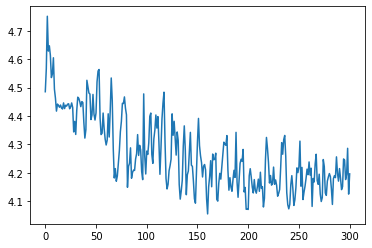

In [37]:
plt.plot(loss_list)

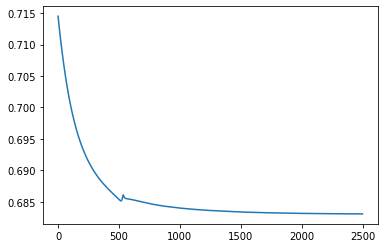

In [52]:
plt.plot(loss_list[500:])

In [2]:
plt.plot(loss_list[500:])

NameError: ignored

# Testing

Testing cell

In [51]:
mae = 0
tgcn.eval()
with torch.no_grad():
    for data in test_data:
        input, labels = data
        pred = tgcn(input)
        # reshape
        pred = pred.transpose(1, 2).reshape((-1, input.size(2)))
        labels = labels.reshape((-1, labels.size(2)))


        val_loss = mse_with_regularizer_loss_func(pred, labels, tgcn)
        mae = torchmetrics.functional.mean_absolute_error(pred, labels)
        acc = accuracy_func(pred, labels)
        r2 = r2_func(pred, labels)
        explained_var = explained_variance_func(pred, labels)
        mse = torchmetrics.functional.mean_squared_error(pred, labels)
        rmse = torch.sqrt(mse)
        my_rmse = torch.sqrt(mse_loss(pred, labels))
        my_mae = (mae_loss(pred, labels))
        
print('MAE: ' + str(mae.item()))
print('R2: ' + str(r2.item()))
print('MSE: ' + str(mse.item()))
print('RMSE: ' + str(rmse.item()))
print('Acc: ' + str(acc.item()))
print('Var: ' + str(explained_var.item()))
print('val_loss: ' + str(val_loss.item()))
print('my_RMSE: ' + str(my_rmse.item()))
print('my_MAE: ' + str(my_mae.item()))

MAE: 0.0644073337316513
R2: 0.7778406143188477
MSE: 0.008728905580937862
RMSE: 0.0934286117553711
Acc: 0.8886637687683105
Var: 0.7784289121627808
val_loss: 1.8072646856307983
my_RMSE: 1.3442035913467407
my_MAE: 13.332318305969238
